# jupyter notebook 단축키
- 셀위에 셀 생성 : a
- 샐아래 셀 생성 : b
- 셀 삭제 : dd
- 지운셀 복원 : edit -> undo delete cell버튼
- 셀합치기 : shift + m
- 셀 실행 : shift + enter (다음셀로이동) , shift + control (현재셀 다시실행)
- 마크다운 : 셀 비활성화 (파란상태)에서 m버튼

### packages

In [1]:
from IPython.display import display ,HTML
display(HTML("<style>.container {width :95% !important;}</style>"))

!pip install koreanize-matplotlib

# 한글 그래프
import matplotlib.pyplot as plt
import koreanize_matplotlib

plt.rcParams['axes.unicode_minus'] = False #한글 폰트 사용시 마이너스 폰트 깨짐 해결
import seaborn as sns

import pandas as pd
pd.set_option('display.max_columns',200)

#sample etc.
import numpy as np

#pca
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

#t-test
from scipy.stats import ttest_ind


#modeling
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier , DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error


import warnings
warnings.filterwarnings('ignore')


from imblearn.over_sampling import SMOTE
import xgboost as xgb
import scipy.stats as stats
import math
from scipy.stats import chi2_contingency
from statsmodels.stats.multicomp import pairwise_tukeyhsd

## by datamanim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 13.6 MB/s eta 0:00:00


# 29회 ADP 복원

# 기계학습 (60점)

## 데이터 설명
- 데이터 출처 : https://www.data.go.kr/data/15094266/fileData.do 후처리
- 데이터 링크 : https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/29/p1.csv
- 데이터 설명 : 대구도시공사_빅데이터_영구임대아파트 입주자 퇴거여부 데이터, 고유번호를 가진 계약자와 특정 아파트에 대해 매년 퇴거여부를 기록한 데이터

In [2]:
#encoding = ['utf-8','cp949','utf-8-sig','euc-kr','latin']
df =pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/29/p1.csv',encoding= 'cp949')
df.head()

,순번,계약구분,재계약횟수,거주개월,아파트 이름,아파트 ID,아파트 평점,호실고유번호,층,평형대,계약자고유번호,계약서고유번호,입주연도,퇴거연도,거주연도,월세(원),보증금(원),대표나이,나이,성별,결혼여부,거주자 수,퇴거여부
0,1,유효,10,222,강남아파트,5,7.0,14520,1,12,15468,15865,2003,NaN,2008,47100,3646000,46,33,남,미혼,3,미퇴거
1,1,유효,10,222,강남아파트,5,7.0,14520,1,12,15468,15865,2003,NaN,2009,56500,4375000,46,34,남,미혼,3,미퇴거
2,1,유효,10,222,강남아파트,5,7.0,14520,1,12,15468,15865,2003,NaN,2010,56500,4375000,46,35,남,미혼,3,미퇴거
3,1,유효,10,222,강남아파트,5,7.0,14520,1,12,15468,15865,2003,NaN,2011,69900,5408000,46,36,남,미혼,3,미퇴거
4,1,유효,10,222,강남아파트,5,7.0,14520,1,12,15468,15865,2003,NaN,2012,69900,5408000,46,37,남,미혼,3,미퇴거


## 1-1  계약자고유번호를 기준으로 거주연도 별 여러개의 데이터가 쌓여 있다. 각 계약자고유번호에 대해 가장 최신의 거주연도 행만 남겨라.

In [3]:
result = df.sort_values(['계약자고유번호','거주연도']).drop_duplicates('계약자고유번호',keep='last').reset_index(drop=True)
display(result.head(3))
print('답안\n계약자 고유번호 거주연도 기준으로 정렬하고 계약자 고유번호가 중복인 데이터를 제거한다.')

,순번,계약구분,재계약횟수,거주개월,아파트 이름,아파트 ID,아파트 평점,호실고유번호,층,평형대,계약자고유번호,계약서고유번호,입주연도,퇴거연도,거주연도,월세(원),보증금(원),대표나이,나이,성별,결혼여부,거주자 수,퇴거여부
0,12673,해지,4,88,지산5단지아파트,3,8.0,85369,6,12,1,1,2005,2012.0,2012,77300,5302000,44,35,남,기혼,2,퇴거
1,12683,해지,7,174,지산5단지아파트,3,8.0,85421,6,15,6,6,2001,2016.0,2016,48600,2144000,32,27,남,미혼,1,퇴거
2,12702,유효,10,237,지산5단지아파트,3,8.0,85576,7,15,14,14,2001,NaN,2020,81600,5598000,67,66,남,미혼,1,미퇴거


답안
계약자 고유번호 거주연도 기준으로 정렬하고 계약자 고유번호가 중복인 데이터를 제거한다.


## 1-2 결측치 처리

In [4]:
pre_df = result.copy()
dic = {'퇴거':'해지','미퇴거':'유효'}

pre_df['계약구분'] = pre_df['퇴거여부'].map(dic)
dic_apt = {'강남아파트': 7.0, '까치아파트': 10.0, '비둘기아파트': 5.0, '용지아파트': 7.0, '지산5단지아파트': 8.0}
pre_df['아파트 평점'] = pre_df['아파트 이름'].map(dic_apt)
pre_df = pre_df.drop(columns =['퇴거연도'])
display(result.isnull().sum().where(lambda x : x != 0).dropna().to_frame().rename(columns ={0:'결측치 숫자'}).astype('int'))

print('답안\n기존 데이터의 결측치는 계약구분, 아파트 평점, 퇴거연도 3가지 컬럼에서 존재한다.')
print('계약구분의 경우 퇴거여부와 1대1 매핑이 되고, 아파트 평점의 경우에도 아파트 이름에 따라 1대1 매핑됨을 확인했다. 이를 통해 결측치를 대치한다.')
print('퇴거 연도의 경우 현재 "미퇴거" 상태라면 존재하지 않는 값이기 때문에 컬럼 자체를 제거한다.')

,결측치 숫자
계약구분,61
아파트 평점,141
퇴거연도,6257


답안
기존 데이터의 결측치는 계약구분, 아파트 평점, 퇴거연도 3가지 컬럼에서 존재한다.
계약구분의 경우 퇴거여부와 1대1 매핑이 되고, 아파트 평점의 경우에도 아파트 이름에 따라 1대1 매핑됨을 확인했다. 이를 통해 결측치를 대치한다.
퇴거 연도의 경우 현재 "미퇴거" 상태라면 존재하지 않는 값이기 때문에 컬럼 자체를 제거한다.


## 1-3 이상치 처리

In [5]:
pre_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10348 entries, 0 to 10347
Data columns (total 22 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   순번       10348 non-null  int64  
 1   계약구분     10348 non-null  object 
 2   재계약횟수    10348 non-null  int64  
 3   거주개월     10348 non-null  int64  
 4   아파트 이름   10348 non-null  object 
 5   아파트 ID   10348 non-null  int64  
 6   아파트 평점   10348 non-null  float64
 7   호실고유번호   10348 non-null  int64  
 8   층        10348 non-null  int64  
 9   평형대      10348 non-null  int64  
 10  계약자고유번호  10348 non-null  int64  
 11  계약서고유번호  10348 non-null  int64  
 12  입주연도     10348 non-null  int64  
 13  거주연도     10348 non-null  int64  
 14  월세(원)    10348 non-null  int64  
 15  보증금(원)   10348 non-null  int64  
 16  대표나이     10348 non-null  int64  
 17  나이       10348 non-null  int64  
 18  성별       10348 non-null  object 
 19  결혼여부     10348 non-null  object 
 20  거주자 수    10348 non-null  int64  
 21  퇴거여부     103

In [6]:
df1 = pre_df.copy()
df1.head()

,순번,계약구분,재계약횟수,거주개월,아파트 이름,아파트 ID,아파트 평점,호실고유번호,층,평형대,계약자고유번호,계약서고유번호,입주연도,거주연도,월세(원),보증금(원),대표나이,나이,성별,결혼여부,거주자 수,퇴거여부
0,12673,해지,4,88,지산5단지아파트,3,8.0,85369,6,12,1,1,2005,2012,77300,5302000,44,35,남,기혼,2,퇴거
1,12683,해지,7,174,지산5단지아파트,3,8.0,85421,6,15,6,6,2001,2016,48600,2144000,32,27,남,미혼,1,퇴거
2,12702,유효,10,237,지산5단지아파트,3,8.0,85576,7,15,14,14,2001,2020,81600,5598000,67,66,남,미혼,1,미퇴거
3,12789,유효,10,227,지산5단지아파트,3,8.0,86179,10,19,27,27,2002,2020,66600,3116000,61,60,남,기혼,3,미퇴거
4,12796,유효,10,222,지산5단지아파트,3,8.0,86224,10,15,40,40,2003,2020,129240,8865600,58,57,여,미혼,2,미퇴거


Index(['순번', '계약구분', '재계약횟수', '거주개월', '아파트 이름', '아파트 ID', '아파트 평점', '호실고유번호',
       '층', '평형대', '계약자고유번호', '계약서고유번호', '입주연도', '거주연도', '월세(원)', '보증금(원)',
       '대표나이', '나이', '성별', '결혼여부', '거주자 수', '퇴거여부'],
      dtype='object')


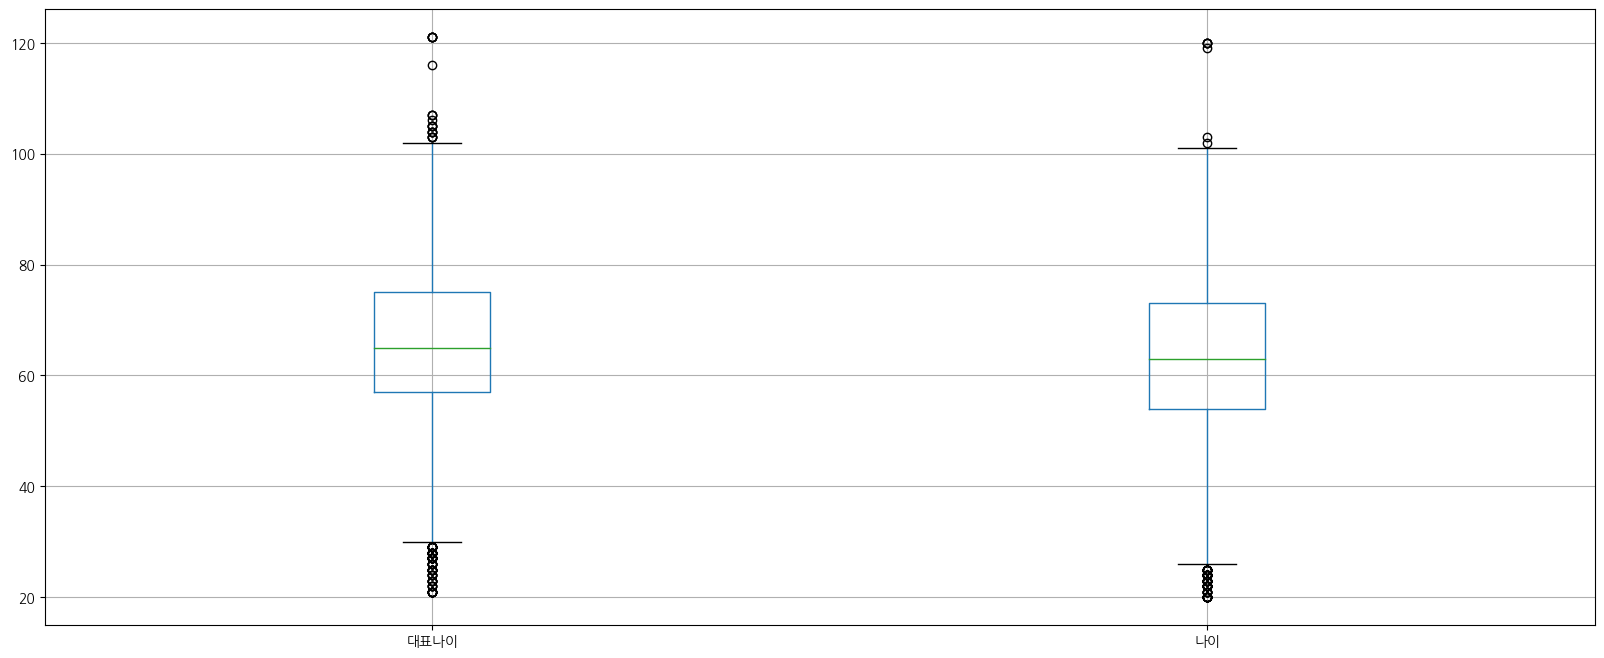

In [7]:
# object = ['계약구분', '아파트 이름','성별','결혼여부']

# for i in object:
#     df1[i] = df1[i].astype('category').cat.codes

# for i in object:
#     print(df1[i].unique())

a = df1.columns
print(a)
# a = ['순번', '재계약횟수', '거주개월', '아파트 ID', '아파트 평점', '호실고유번호',
#        '층', '평형대', '계약자고유번호', '계약서고유번호', '입주연도', '거주연도', '월세(원)', '보증금(원)',
#        '대표나이', '나이', '거주자 수']

b = ['대표나이', '나이']

import matplotlib.pyplot as plt

plt.figure(figsize=(20,8))
float_cols=df1[b]
float_cols.boxplot()
plt.show()

In [8]:
df1.describe()

,순번,재계약횟수,거주개월,아파트 ID,아파트 평점,호실고유번호,층,평형대,계약자고유번호,계약서고유번호,입주연도,거주연도,월세(원),보증금(원),대표나이,나이,거주자 수
count,10348.000000,10348.000000,10348.000000,10348.000000,10348.000000,10348.000000,10348.000000,10348.000000,10348.000000,10348.000000,10348.000000,10348.000000,10348.000000,1.034800e+04,10348.000000,10348.000000,10348.000000
mean,6422.183610,5.873695,137.773579,1.809432,6.363645,42980.835330,7.861229,13.220236,48508.618187,46320.571415,2007.092482,2017.752319,63941.468883,3.807054e+06,65.874758,62.627078,1.688152
std,3729.145894,3.215195,77.544927,0.866580,1.284676,25016.449224,4.284426,2.338369,26845.947221,26014.408368,6.224812,3.639131,40259.713978,3.087981e+06,13.787216,14.179781,0.985380
min,1.000000,1.000000,1.000000,1.000000,5.000000,1.000000,1.000000,12.000000,1.000000,1.000000,1994.000000,2008.000000,31300.000000,1.520000e+06,21.000000,20.000000,1.000000
25%,3175.250000,3.000000,71.000000,1.000000,5.000000,21277.750000,4.000000,12.000000,25058.750000,23252.000000,2002.000000,2016.000000,42300.000000,2.052000e+06,57.000000,54.000000,1.000000
50%,6458.500000,6.000000,137.000000,2.000000,7.000000,42946.000000,8.000000,12.000000,48593.500000,48036.500000,2004.000000,2020.000000,44700.000000,2.304000e+06,65.000000,63.000000,1.000000
75%,9637.500000,9.000000,222.000000,2.000000,7.000000,64589.500000,12.000000,12.000000,74050.250000,69061.250000,2012.000000,2020.000000,66700.000000,3.943000e+06,75.000000,73.000000,2.000000
max,12883.000000,12.000000,323.000000,5.000000,10.000000,86891.000000,15.000000,19.000000,86892.000000,86904.000000,2020.000000,2020.000000,311080.000000,2.078400e+07,121.000000,120.000000,10.000000


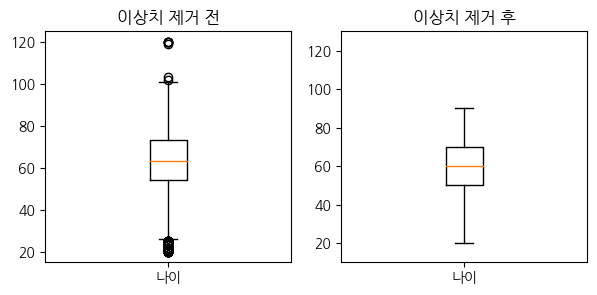

In [9]:
df1['나이이상치_제거'] = (df1['나이'] //10 *10).map(lambda x : 90 if x >=90 else x)
fig,ax = plt.subplots(1,2,figsize=(7,3))
ax[0].boxplot(df1['나이'])
ax[1].boxplot(df1['나이이상치_제거'])
ax[0].set_title('이상치 제거 전')
ax[1].set_title('이상치 제거 후')
ax[1].set_ylim(10,130)
ax[0].set_xticks([1],['나이'])
ax[1].set_xticks([1],['나이'])
plt.show()


### 답안)
- 1.이상치가 존재하는 컬럼은 월세, 보증금, 대표나이, 나이 이다.
- 2.월세 ,보증금이상치들을 보면 비슷한 평형대에 비슷한 가격이 매겨진것을 보면  
  아파트에 평형대에 따라 가격기 다르게 매겨지는것으로 판다 이상치로 보지
  않는다. 그러나 월세가 아주 비싼 것도 존재하는다.
- 3.대표나이와 나이를 보면 최대 나이가 120살로 이상치로 판단할수 있다.
  121 살이 두명존재한다. 이들은 2개를 임으로 제거한다.


## 2-1 재계약 횟수의 중앙값을 기준으로 중앙값보다 크거나 같으면 '높음', 작으면 '낮음' 으로 재계약 횟수 이분 변수를 구성하시오.

In [10]:
med=df1['재계약횟수'].median()
print(med)
df1['이분변수'] = df1['재계약횟수'].map(lambda x : '높음' if x >= med else '낮음')
display(df1['이분변수'].value_counts().to_frame())
print('답안\n중앙값은 6이다. 이를 기준으로 이분변수를 나누고 새로운 컬럼을 만든다. ')

6.0


,이분변수
높음,5388
낮음,4960


답안
중앙값은 6이다. 이를 기준으로 이분변수를 나누고 새로운 컬럼을 만든다. 


## 2-2 차원축소의 필요성을 논하고, 필요에 따라 차원을 축소하고 불필요하다면 그 근거를 논하시오.

In [11]:
p_df = df1.drop(columns = ['순번','아파트 이름','호실고유번호','계약자고유번호','계약서고유번호','대표나이','나이'])
p_df['월세(만원)'] = p_df['월세(원)']/10000
p_df['보증금(백만원)'] = p_df['보증금(원)']/1000000
p_df = p_df.drop(columns = ['월세(원)','보증금(원)'])
# print(p_df.head(3))

#차원축소 및 스케일링
#DataFrame p_df의 object dtype을 가진 모든 열을 반복합니다.
for col in p_df.select_dtypes(include= object):
    # 각 열에 대해 LabelEncoder 객체를 생성하고 열의 값에 맞게 학습시킵니다.
    lb = LabelEncoder()
    # 학습된 LabelEncoder 객체를 사용하여 열의 값을 정수로 변환합니다.
    p_df[col] = lb.fit_transform(p_df[col])

# print(p_df.head(3))

# PCA 객체를 생성
pca = PCA()
#DataFrame pca_df에 맞게 학습시킵니다.
mm = MinMaxScaler()
pca_df = pd.DataFrame(mm.fit_transform(p_df))
# print(pca_df.head(3))

pca_df.columns = p_df.columns
# print(pca_df.head(3))

pca.fit(pca_df)

# 각 주성분에 대한 설명된 분산 비율을 포함하는 DataFrame ratio를 생성합니다.
ratio = pd.DataFrame(pca.explained_variance_ratio_,columns =['ratio'])

# 각 주성분에 대한 설명된 분산 비율의 누적 합을 계산합니다.
ratio['cumsum'] =ratio['ratio'].cumsum()

# DataFrame ratio의 열 이름을 variance_ratio와 cumsum으로 바꿉니다.
ratio.columns = ['variance_ratio','cumsum']

# DataFrame ratio의 인덱스 이름을 PC_1, PC_2, ... 등으로 바꿉니다.
ratio.index = ['PC_' + str(i+1) for i in ratio.index]

display(ratio.round(2).T)
print('답안\n순번,아파트 이름 호실 고유번호, 계약자 고유번호, 계약서 고유번호는 데이터 구분을 위한 특정 PK이기 때문에 제거한다.')
print('대표나이의 경우 2020년 기준의 나이이기 때문에 제거한다. 나이 컬럼은 이상치 제거한 컬럼이 있기 때문에 제거한다.')
print('범주형 변수에 대해서 라벨인코딩을 진행한 후 min-max 스케일링을 하고 pca를 진행한다.')
print('분산설명력의 경우 7개의 주축을 선택할 경우 92% 데이터 설명이 가능하다.')
print('전체 컬럼의 숫자가 17개로 많지 않고 데이터 설명을 위한 데이터 주축의 숫자가 많이 필요 하기 때문에 굳이 차원 축소를 하지 않겠다.')

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13,PC_14,PC_15,PC_16,PC_17
variance_ratio,0.34,0.20,0.15,0.07,0.06,0.05,0.04,0.02,0.02,0.02,0.01,0.0,0.0,0.0,0.0,0.0,0.0
cumsum,0.34,0.54,0.69,0.77,0.82,0.87,0.92,0.94,0.96,0.98,0.99,1.0,1.0,1.0,1.0,1.0,1.0


답안
순번,아파트 이름 호실 고유번호, 계약자 고유번호, 계약서 고유번호는 데이터 구분을 위한 특정 PK이기 때문에 제거한다.
대표나이의 경우 2020년 기준의 나이이기 때문에 제거한다. 나이 컬럼은 이상치 제거한 컬럼이 있기 때문에 제거한다.
범주형 변수에 대해서 라벨인코딩을 진행한 후 min-max 스케일링을 하고 pca를 진행한다.
분산설명력의 경우 7개의 주축을 선택할 경우 92% 데이터 설명이 가능하다.
전체 컬럼의 숫자가 17개로 많지 않고 데이터 설명을 위한 데이터 주축의 숫자가 많이 필요 하기 때문에 굳이 차원 축소를 하지 않겠다.


## 3-1 재계약 횟수 이분변수를 기준으로 세그먼트를 구분하고 각 세그먼트의 특징을 분석하시오.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10348 entries, 0 to 10347
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   계약구분      10348 non-null  int64  
 1   재계약횟수     10348 non-null  int64  
 2   거주개월      10348 non-null  int64  
 3   아파트 ID    10348 non-null  int64  
 4   아파트 평점    10348 non-null  float64
 5   층         10348 non-null  int64  
 6   평형대       10348 non-null  int64  
 7   입주연도      10348 non-null  int64  
 8   거주연도      10348 non-null  int64  
 9   성별        10348 non-null  int64  
 10  결혼여부      10348 non-null  int64  
 11  거주자 수     10348 non-null  int64  
 12  퇴거여부      10348 non-null  int64  
 13  나이이상치_제거  10348 non-null  int64  
 14  이분변수      10348 non-null  int64  
 15  월세(만원)    10348 non-null  float64
 16  보증금(백만원)  10348 non-null  float64
dtypes: float64(3), int64(14)
memory usage: 1.3 MB


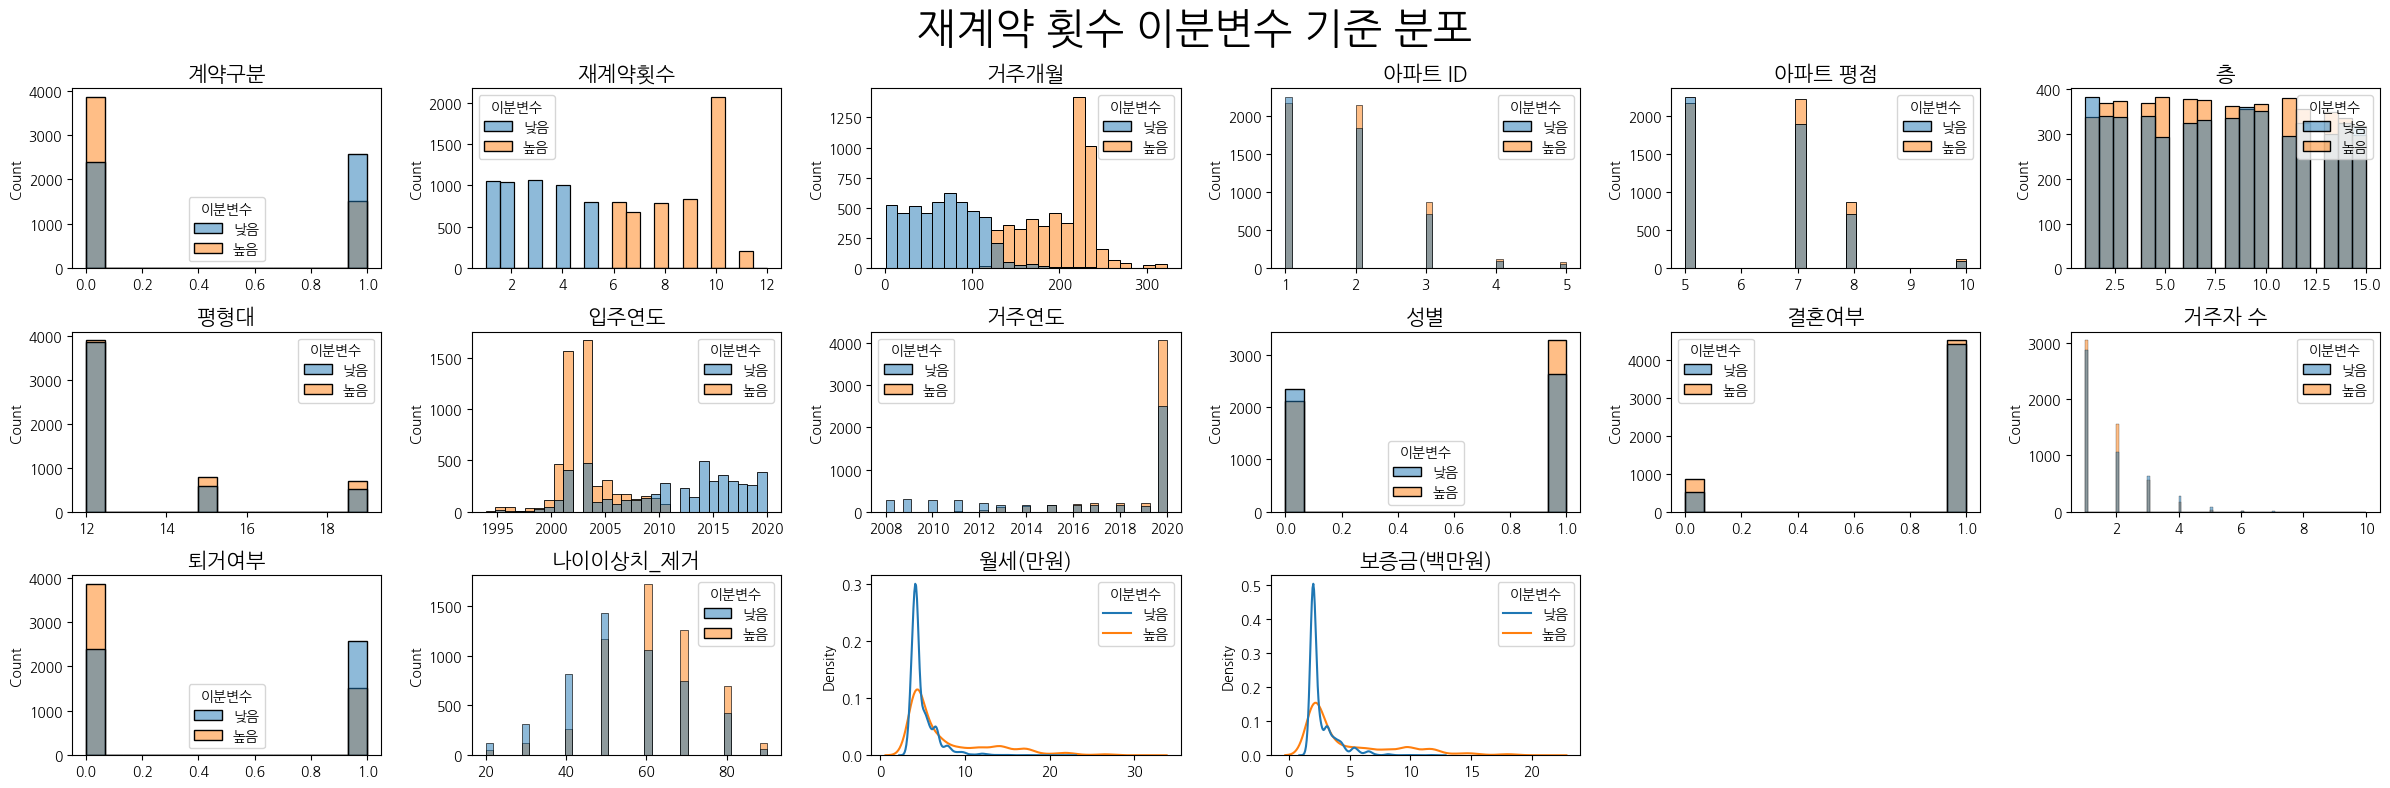

,계약구분,재계약횟수,거주개월,아파트 ID,아파트 평점,층,평형대,입주연도,거주연도,성별,결혼여부,거주자 수,퇴거여부,나이이상치_제거,월세(만원),보증금(백만원)
p-value,0.0,0.0,0.0,0.0,0.0,0.85174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


답안
이분변수를 기준으로 각 컬럼의 분포에 대한 그래프이다. 이분변수를 기준으로 큰 차이를 보이는 것은 재계약 횟수, 거주개월, 입주연도, 월세,보증금이다.
이분변수는 재계약 횟수 중앙값을 기준으로 만든것이기에 거주개월에 대해서는 어느정도 상관성을 보임을 추측 할 수 있다. 거주개월이 긴 경우는 입주연도도 길 것이다.
보증금과 월세의 경우의 경우 이분변수가 높은 경우 분산이 더 크다.
층을 제외하고는 모든 변수에서 유의 수준 0.05하에서 이분변수 간의 차이가 존재한다.
아파트 ID와 층에 따라서는 크게 이분변수의 차이가 존재하지 않는다. 나이의 경우 이분변수가 높을 경우 평균 연령이 높다


In [12]:
p_value_lst = []
dfX = p_df.copy()
# fig은 그림 객체를, ax는 서브플롯 배열을 가리킵니다.
# nrows는 행의 개수, ncols는 열의 개수를 지정합니다. figsize는 그림의 크기를 지정합니다.
fig,ax = plt.subplots(3,6,figsize=(24,8))

# ax.flat[:-2]에 있는 각 서브플롯을 반복합니다.
# ax.flat은 ax의 모든 서브플롯을 하나의 배열로 반환합니다.
# :-2는 마지막 두 개의 서브플롯을 제외하고 모든 서브플롯을 반환합니다.
# 이 코드에서 i는 서브플롯의 인덱스를 나타냅니다. axes는 서브플롯 객체를 가리킵니다.
# 각 반복에서 i와 axes는 for 루프의 외부에서 선언된 변수에 할당됩니다.
# 이렇게 하면 각 서브플롯에 대한 정보를 유지할 수 있습니다.
dfX.info()
for i,axes in enumerate(ax.flat[:-2]):
  target_columns = dfX.drop(columns =['이분변수']).columns[i]
  target_df = dfX[[target_columns,'이분변수']]
  target_df['이분변수'] = target_df['이분변수'].map({0:'낮음',1:'높음'}) # 라벨인코딩시에 어떤 레이블링을 했는지 확인해야함

  # ttest_ind() 함수는 두 그룹의 평균 차이에 대한 t 검정을 수행합니다.
  # 이 함수는 두 그룹의 평균, 두 그룹의 분산, 두 그룹의 크기를 입력으로 받습니다.
  # p-value는 t 검정의 유의 수준을 나타냅니다. p-value가 0.05 미만이면 두 그룹의 평균 차이가 통계적으로 유의하다고 간주합니다.
  t_statistic, p_value = ttest_ind(target_df.query('이분변수 =="높음"')[target_columns], target_df.query('이분변수 =="낮음"')[target_columns])
  p_value_lst.append([target_columns,round(p_value,5)])


  if '월세' not in target_columns and '보증금' not in target_columns:
      sns.histplot(data=target_df ,x= target_columns,hue= '이분변수',ax = axes)
      axes.set_xlabel('')
      axes.set_title(target_columns,fontsize=15)
  else:
      sns.kdeplot(data=target_df ,x= target_columns,hue= '이분변수',ax = axes,)
      axes.set_xlabel('')
      axes.set_title(target_columns,fontsize=15)

ax.flat[-1].remove()
ax.flat[-2].remove()
fig.suptitle('재계약 횟수 이분변수 기준 분포',fontsize=30)
fig.tight_layout()
plt.show()

pv_df = pd.DataFrame(p_value_lst).set_index(0).T
pv_df.index = ['p-value']

display(pv_df)

print('답안')
print('이분변수를 기준으로 각 컬럼의 분포에 대한 그래프이다. 이분변수를 기준으로 큰 차이를 보이는 것은 재계약 횟수, 거주개월, 입주연도, 월세,보증금이다.')
print('이분변수는 재계약 횟수 중앙값을 기준으로 만든것이기에 거주개월에 대해서는 어느정도 상관성을 보임을 추측 할 수 있다. 거주개월이 긴 경우는 입주연도도 길 것이다.')
print('보증금과 월세의 경우의 경우 이분변수가 높은 경우 분산이 더 크다.')
print('층을 제외하고는 모든 변수에서 유의 수준 0.05하에서 이분변수 간의 차이가 존재한다.')
print('아파트 ID와 층에 따라서는 크게 이분변수의 차이가 존재하지 않는다. 나이의 경우 이분변수가 높을 경우 평균 연령이 높다')

## 3-2. 재계약횟수 변수를 종속변수로 하는 회귀 분석을 두 가지 이상의 방법론을 통해 수행하고 최종 모델을 결정하시오. 재계약횟수 이분변수를 종속변수로 하는 분류 분석을 두가지 이상의 방법론을 통해 수행하고 최종 모델을 결정하시오.

In [13]:
df1 = p_df.copy()
preprocessing_df = df1
preprocessing_df = preprocessing_df.rename(columns ={'이분변수':'y'})

# 스케일링 안해도되는 장점있고, 변수 중요도 확인 가능한 트리류 계열끼리 비교
# 최종 결과의 경우에도 하나의 데이터 프레임으로 정리하는게 좋지 않을까 / 다양한 모델 및 모델 최적화 과정보다 답변 깔끔하게 쓰는게 더 중요 할듯

x = preprocessing_df.drop(columns =['y','재계약횟수','거주개월','거주연도','입주연도'])
reg_y = preprocessing_df['재계약횟수'] #회귀분석 종속변수
cls_y = preprocessing_df['y']         #분류분석 종속변수

#회귀분석
reg_rf = RandomForestRegressor(random_state =3)
reg_dc = DecisionTreeRegressor(random_state =3)

#분류분석
cls_rf = RandomForestClassifier(random_state =3)
cls_dc = DecisionTreeClassifier(random_state =3)


def model_(model,types,name):
    if types =='reg':
        x_train, x_test, y_train, y_test = train_test_split(x, reg_y, test_size=0.33, random_state=42)
        model.fit(x_train,y_train)
        pred = model.predict(x_test)
        acc = mean_squared_error(y_test,pred)
        acc_name = 'mse'

    elif types =='cls':
        x_train, x_test, y_train, y_test = train_test_split(x, cls_y, test_size=0.33, random_state=42)
        model.fit(x_train,y_train)
        pred = model.predict(x_test)
        acc = accuracy_score(y_test,pred)
        acc_name = 'accuracy_score'

    return {name:acc},model,acc_name

lst = {}
model_lst = []
name_lst = []
for models in [[reg_rf,'reg','randomforest_regressor'],
               [reg_dc,'reg','decisiontree_regressor'],
               [cls_rf,'cls','randomforest_classification'],
               [cls_dc,'cls','decisiontree_classification']]:
    model = models[0]
    types = models[1]
    name = models[2]
    acc, model, name = model_(model, types, name)
    print(acc, model, name)
    lst.update(acc)
    model_lst.append(model)
    name_lst.append(name)

models = pd.DataFrame(lst.items(), columns = ['model','test_set_accuracy']).set_index('model').reset_index()
display(models.round(2))
print('답안\n')
print('이분변수는 재계약 횟수를 기준으로 만들었고 재계약 횟수는 거주개월과 거주연도 입주연도와 높은 상관성을 띄기에 이 컬럼들을 제거하고 모델을 생성한다.')
print('모델의 변수중요도를 확인하기 위해 트리류 모델들로 비교한다. 회귀모델과 분류 모델 각 경우 랜덤포레스트와 결정트리 모델에 대해 학습하고 결과를 비교한다.')
print('분류의 경우 정확도로 모델을 평가하고 회귀모델의 경우 평균제곱오차를 통해 모델을 비교한다. 정확도는 숫자가 클수록 좋은 모델이고')
print('mse는 그 값이 작을 수록 모델 오차가 작다고 판단 할 수 있다. 67%의 데이터로 학습하고, 33%의 모델로 평가했을 때')
print("분류, 회귀 모두 랜덤포레스트 모델이 더 좋은 성능을 가졌다.")
print('의사결정나무에 비해 랜덤포레스트 모델은 많은 앙상블 과정을 거치기에 과적합이 적어서 이런 결과가 나온것으로 보인다.')

{'randomforest_regressor': 7.222368218724643} RandomForestRegressor(random_state=3) mse
{'decisiontree_regressor': 11.02951377674953} DecisionTreeRegressor(random_state=3) mse
{'randomforest_classification': 0.7068814055636896} RandomForestClassifier(random_state=3) accuracy_score
{'decisiontree_classification': 0.6857979502196193} DecisionTreeClassifier(random_state=3) accuracy_score


,model,test_set_accuracy
0,randomforest_regressor,7.22
1,decisiontree_regressor,11.03
2,randomforest_classification,0.71
3,decisiontree_classification,0.69


답안

이분변수는 재계약 횟수를 기준으로 만들었고 재계약 횟수는 거주개월과 거주연도 입주연도와 높은 상관성을 띄기에 이 컬럼들을 제거하고 모델을 생성한다.
모델의 변수중요도를 확인하기 위해 트리류 모델들로 비교한다. 회귀모델과 분류 모델 각 경우 랜덤포레스트와 결정트리 모델에 대해 학습하고 결과를 비교한다.
분류의 경우 정확도로 모델을 평가하고 회귀모델의 경우 평균제곱오차를 통해 모델을 비교한다. 정확도는 숫자가 클수록 좋은 모델이고
mse는 그 값이 작을 수록 모델 오차가 작다고 판단 할 수 있다. 67%의 데이터로 학습하고, 33%의 모델로 평가했을 때
분류, 회귀 모두 랜덤포레스트 모델이 더 좋은 성능을 가졌다.
의사결정나무에 비해 랜덤포레스트 모델은 많은 앙상블 과정을 거치기에 과적합이 적어서 이런 결과가 나온것으로 보인다.


## 3-3 최종 채택한 모델에서 각각 유의하게 작용하는 변수를 확인 하고 설명하시오

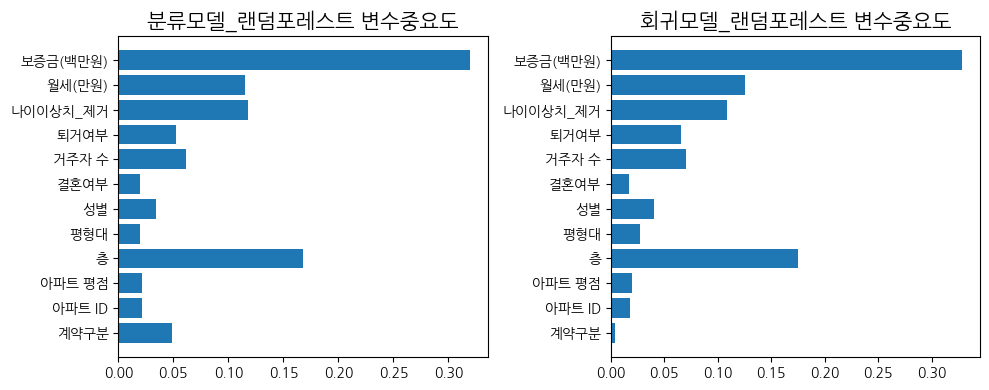

답안

분류모델의 경우 보증금, 월세, 층 순서로 중요도를 보였고
회귀 모델의 경우 보증금, 층, 나이이상치 제거 순서로 변수 중요도를 보였다


In [14]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
#feature_importances_의 값이 클수록 해당 feature가 모델의 예측에 더 중요한 역할을 합니다.
ax[0].barh(model_lst[0].feature_names_in_,model_lst[0].feature_importances_)
ax[1].barh(model_lst[2].feature_names_in_,model_lst[-1].feature_importances_)

ax[0].set_title('분류모델_랜덤포레스트 변수중요도',fontsize=15)
ax[1].set_title('회귀모델_랜덤포레스트 변수중요도',fontsize=15)
fig.tight_layout()
plt.show()

print('답안\n')
print('분류모델의 경우 보증금, 월세, 층 순서로 중요도를 보였고')
print('회귀 모델의 경우 보증금, 층, 나이이상치 제거 순서로 변수 중요도를 보였다')

## 3-4 해당 데이터 분석결과로 얻을 수 있는 점 제시

In [15]:
r= df1[['이분변수','월세(만원)','보증금(백만원)','나이이상치_제거','입주연도']].groupby(['이분변수']).agg(['median']).round(2)
r.index = ['낮음','높음']
display(r)
print('재계약 횟수의 중앙값을 기준으로 세그먼트를 나눠 분석해 보았다.')
print('층수의 경우 이분변수간 통계적으로 유의한 차이를 보이지 않았지만, 모델에서는 상위 구분을 위한 중요도를 보였다.')
print('재계약 횟수가 높은 경우 월세와 보증금의 평균값이 평균 2배 높았고 대표 거주인의 나이도 있고 7살 많았다.')

# 뭔가 더 인사이트가 한두줄 더 들어가야 할 것 같습니다 ㅎㅎ;

,월세(만원),보증금(백만원),나이이상치_제거,입주연도
,median,median,median,median
낮음,4.32,2.06,50.0,2013.0
높음,5.27,2.99,60.0,2003.0


재계약 횟수의 중앙값을 기준으로 세그먼트를 나눠 분석해 보았다.
층수의 경우 이분변수간 통계적으로 유의한 차이를 보이지 않았지만, 모델에서는 상위 구분을 위한 중요도를 보였다.
재계약 횟수가 높은 경우 월세와 보증금의 평균값이 평균 2배 높았고 대표 거주인의 나이도 있고 7살 많았다.


## 데이터 설명
- 데이터 출처 : https://www.kaggle.com/datasets/pschale/mlb-pitch-data-20152018 데이터를 후처리
- 데이터 링크 : https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/29/p2_.csv
- 데이터 설명 :

A 야구구단의 시합 결과중 일부를 나타낸다.    
각 행은 하나의 경기를 의미(game_id)하며 9회차(= 9이닝) 동안 1번타자, 2번타자의 출루 정보를 의미한다.     
각 컬럼에 대한 설명은 아래 이미지와 같으며, value값의 index는 이미지의 '수치 의미' 열을 통해 확인 할 수 있다.


<img src="https://github.com/Datamanim/datarepo/blob/main/adp/29/p1_img.png?raw=true" width="500" height="600">

## 4-1 각 회차별로 1번 타자의 출루 (1,2,3루타와 사사구(볼넷, 몸에맞는공))가 있는 경우에 대해 득점이 발생 했는지 확인하고자 한다. 이를 위한 전처리를 수행하라. (단, 첫 번째 혹은 두 번째 타자가 홈런을 친 경우 해당 회차 데이터는 제외한다.)     

조건1 : 득점여부를 범주형 종속변수로 한다. (1점이상 득점 :1, 무득점 :0)     
조건2 : 각 회차 2번 타자의 데이터는 원핫 인코딩한다.    
조건3 : 학습에 적절하지 않은 데이터는 제외한다.    

제가 이해하고 의도한 29회 4-1번 문제에 대한 가이드 입니다.
(4-1) 전처리 가이드
1. 첫타자와 둘째타자의 각 이닝별 출루현황, 해당 이닝의 득점수를 3columns의 데이터로 변환
2. 정수형 값이 아닌 데이터 행를 제거
3. 홈런 (4)값을 가지는 행을 제거
4. 이닝별 점수를 binary로 변환 (득점 있으면 1 ,없으면 0 )
5. 둘째 타자 출루 결과를 one-hot encoding

In [23]:
df =pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/29/p2_.csv')

#df에서 1~9이닝까지를 나워서 lst를 만든다
#분석할수 있도록 df를 다시 만든다
lst = []
for i in range(1,10):
    each_innings_df = df[['game_id',f'a{i}_1',f'a{i}_2',f'b{i}']].reset_index(drop=True)
    each_innings_df.columns =['game_id','first_hitter','second_hitter','inning_score']
    each_innings_df.loc[:,'inning'] = i
    lst.append(each_innings_df)

#만든 리스트를 합친다
t = pd.concat(lst).reset_index(drop=True)

#숫자가 아닌 열은 걸러낸다.
# lambda x : str(x).isdigit()은 x가 숫자인지 여부를 확인하는 람다 함수입니다.
tt = t[t.first_hitter.map(lambda x : str(x).isdigit())].reset_index(drop=True)
tt.first_hitter =tt.first_hitter.astype('int')
tt.second_hitter =tt.second_hitter.astype('int')

#첫번째 혹은 두번쨰 타자가 홈런을 친경우는 제외한다
tts = tt[(tt.first_hitter != 4) & (tt.second_hitter != 4)].reset_index(drop=True)

#득점여부를 범주형 종속변수로 한다. (1점이상 득점 :1, 무득점 :0)
tts.inning_score =tts.inning_score.map(lambda x : 1 if x >0 else 0)

#두번째 타자만 원핫인코딩
sec = pd.get_dummies(tts.second_hitter.astype('str'))
sec.columns = ['second_hitter_' + str(x) for x in sec.columns]

g = pd.concat([tts[['game_id','first_hitter','inning_score','inning']],sec],axis=1)
result= g[['game_id','inning', 'first_hitter', 'second_hitter_1','second_hitter_2', 'second_hitter_3', 'second_hitter_5','second_hitter_6', 'second_hitter_7', 'second_hitter_8','second_hitter_9','inning_score']]
result['first_hitter'] = result['first_hitter'].map(lambda x : 1 if x in [1,2,3,6,8] else 0 )
result.head()

,game_id,inning,first_hitter,second_hitter_1,second_hitter_2,second_hitter_3,second_hitter_5,second_hitter_6,second_hitter_7,second_hitter_8,second_hitter_9,inning_score
0,201900016,1,0,0,0,0,1,0,0,0,0,0
1,201900103,1,0,0,0,0,0,1,0,0,0,0
2,201900112,1,0,0,0,0,0,0,1,0,0,0
3,201900131,1,0,1,0,0,0,0,0,0,0,0
4,201900141,1,1,0,0,0,1,0,0,0,0,0


## 4-2 4-1 데이터에 대해 Logistic Regression을 적용하고 2번타자의 희생번트 여부에 대한 회귀 계수 검정을 하라

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

x = result.drop(columns =['game_id','inning_score','inning'])
y = result['inning_score']

model = sm.Logit(y,x)   # 로지스틱 회귀 모델 생성
res = model.fit(disp=False)   # 모델 피팅
display(res.summary().tables[1]) # 회귀 계수에 대한 검정 결과 출력

print('답안\n2번타자의 희생번트의 경우 second_hitter_9 컬럼의 p-value를 보면된다. 이는 0으로 유의수준 0.05하에서 귀무가설을 기각한다.')
print('즉 해당 변수는 종속 변수에 영향을 준다')

# 로지스틱 회귀 모델의 계수, 표준 오차, z-점수, p-값을 보여줍니다.
# 계수는 각 특성에 대한 회귀선의 추정된 기울기입니다.
# 표준 오차는 추정된 기울기의 표준 편차입니다.
# z-점수는 계수를 표준 오차로 나눈 것입니다.
# p-값은 귀무 가설이 참일 때 z-점수와 같은 극단적인 결과를 얻을 확률입니다.
# p-값이 0.000은 귀무 가설을 매우 높은 신뢰도로 기각할 수 있음을 의미합니다. 즉, 계수는 통계적으로 유의합니다.


# first_hitter: first_hitter 특성에 대한 계수는 1.8849입니다.
# 이는 first_hitter 특성의 단위 증가가 목표 변수의 확률을 1.8849만큼 증가시키는 것과 관련이 있음을 의미합니다.
# second_hitter_9: second_hitter_9 특성에 대한 계수는 -0.9835입니다.
# 이는 second_hitter_9 특성의 단위 증가가 목표 변수의 확률을 0.9835만큼 감소시키는 것과 관련이 있음을 의미합니다.
# 목표 변수의 확률은 목표 변수가 발생할 확률을 목표 변수가 발생하지 않을 확률로 나눈 것입니다.
# 확률이 감소하면 목표 변수가 발생할 확률이 낮아집니다.

,coef,std err,z,P>|z|,[0.025,0.975]
first_hitter,1.8849,0.138,13.618,0.000,1.614,2.156
second_hitter_1,-0.5886,0.146,-4.019,0.000,-0.876,-0.302
second_hitter_2,0.2610,0.251,1.041,0.298,-0.230,0.753
second_hitter_3,2.0157,1.061,1.900,0.057,-0.064,4.095
second_hitter_5,-2.0612,0.122,-16.887,0.000,-2.300,-1.822
second_hitter_6,-0.6097,0.200,-3.047,0.002,-1.002,-0.218
second_hitter_7,-2.5450,0.181,-14.095,0.000,-2.899,-2.191
second_hitter_8,-0.4915,0.579,-0.849,0.396,-1.626,0.643
second_hitter_9,-0.9835,0.273,-3.607,0.000,-1.518,-0.449


답안
2번타자의 희생번트의 경우 second_hitter_9 컬럼의 p-value를 보면된다. 이는 0으로 유의수준 0.05하에서 귀무가설을 기각한다.
즉 해당 변수는 종속 변수에 영향을 준다


## 4-3 SMOTE (random_state =0 지정)를 적용하여 data imbalance를 해결하라

In [33]:
smote = SMOTE(sampling_strategy='auto', random_state=0)
X_resampled, y_resampled = smote.fit_resample(x, y)

result = pd.concat([y.value_counts(),y_resampled.value_counts()],axis=1)
result.columns = ['smote 이전 데이터 분포','smote 이후 데이터 분포']
result.index = ['레이블 0 ','레이블 1']
display(result)
# print('SMOTE를 적용한 후 대상 변수의 분포가 더 균형 잡혀 있음을 보여줍니다. \n
#        소수 클래스 (레이블 1)의 데이터 포인트 수가 증가한 \n
#        반면, 다수 클래스 (레이블 0)의 데이터 포인트 수는 동일하게 유지되었습니다.\n
#        SMOTE는 불균형한 데이터셋의 성능을 향상시키는 데 효과적인 방법입니다. \n
#        SMOTE를 사용하면 모델이 소수 클래스의 데이터 포인트에 대해 더 잘 학습할 수 있습니다.')

,smote 이전 데이터 분포,smote 이후 데이터 분포
레이블 0,1096,1096
레이블 1,511,1096


## 4-4 4-3 구성 데이터에 Logistic Regression을 적용하고 결과를 분석하라

In [37]:
# 문제 표현에 따라 다르게 접근 할듯 / 4-2와의 비교 or 그냥 분류 모델 결과 확인
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.33, random_state=1,stratify=y_resampled)

model = sm.Logit(y_train.reset_index(drop=True), X_train.reset_index(drop=True))
result = model.fit(disp=False)
display(res.summary().tables[1])
acc =accuracy_score(y_test.reset_index(drop=True),result.predict(X_test).map(lambda x : 1 if x>=0.5 else 0))
print('정확도 : ',acc)

,coef,std err,z,P>|z|,[0.025,0.975]
first_hitter,1.8849,0.138,13.618,0.000,1.614,2.156
second_hitter_1,-0.5886,0.146,-4.019,0.000,-0.876,-0.302
second_hitter_2,0.2610,0.251,1.041,0.298,-0.230,0.753
second_hitter_3,2.0157,1.061,1.900,0.057,-0.064,4.095
second_hitter_5,-2.0612,0.122,-16.887,0.000,-2.300,-1.822
second_hitter_6,-0.6097,0.200,-3.047,0.002,-1.002,-0.218
second_hitter_7,-2.5450,0.181,-14.095,0.000,-2.899,-2.191
second_hitter_8,-0.4915,0.579,-0.849,0.396,-1.626,0.643
second_hitter_9,-0.9835,0.273,-3.607,0.000,-1.518,-0.449


정확도 :  0.712707182320442


## 4-5 4-3 구성 데이터에 XGB 적용하고 결과를 분석하라

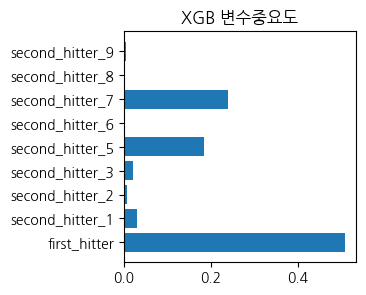

정확도는 69.6 % 이다.
첫번쨰 타자의 출루가 가장큰 변수 중요도를 가지며 그다음으로 2번째 타자의 삼진과 그외 아웃들이 순서를 따른다


In [38]:
model = xgb.XGBClassifier( random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

plt.figure(figsize=(3,3))
plt.barh(model.feature_names_in_,model.feature_importances_)
plt.title('XGB 변수중요도')
plt.show()
print("정확도는", round(accuracy*100,1),'% 이다.\n첫번쨰 타자의 출루가 가장큰 변수 중요도를 가지며 그다음으로 2번째 타자의 삼진과 그외 아웃들이 순서를 따른다')

# 통계 (40점)

## 5. 제품 A의 불량률은 0.03이다. 25개의 제품을 뽑았을 때 3개가 불량일 확률을 구하시오. (소수점 다섯 째 자리에서 반올림)

In [ ]:
# 이항분포 코드 이용한 풀이
n = 25 ;k = 3;p = 0.03
binomial_prob = stats.binom.pmf(k, n, p)
result = round(binomial_prob, 5)


# 확률 풀이
p_defective = 0.03 ; p_good = 0.97 ; num_defective = 3
num_good = 25 - num_defective

probability = (p_defective ** num_defective) * (p_good ** num_good) * math.comb(25, 3)
rounded_probability = round(probability, 5)


print(f'답안\n22개는 정상(확률 0.97) 3개는 불량(확률 0.03)인 이항분포 문제이다.')
print(f'이항분포의 확률 질량함수는 n :시행횟수 , k :불량품갯수 , p : 불량률 일때')
print(f'nCk * (p**k) * (1-p)**(n-k)로 계산할 수 있다. 그 결과는 {rounded_probability}이다')

답안
22개는 정상(확률 0.97) 3개는 불량(확률 0.03)인 이항분포 문제이다.
이항분포의 확률 질량함수는 n :시행횟수 , k :불량품갯수 , p : 불량률 일때
nCk * (p**k) * (1-p)**(n-k)로 계산할 수 있다. 그 결과는 0.03177이다


## 6. C사 생산 제품 1000개 중 양품이 600개, D사 생산 제품 500개 중 양품이 200개 이다. 두 회사의 양품률에 차이가 있는지 검정하여라.

In [ ]:
# sol1. Z검정 p-value
p1 = 0.6;p2 = 0.4
n1 = 1000;n2 = 500
SE = math.sqrt((p1 * (1 - p1) / n1) + (p2 * (1 - p2) / n2)) # 표준 오차 계산
Z = (p1 - p2) / SE # Z-점수 계산
p_value = 2 * (1 - stats.norm.cdf(abs(Z))) # p-value 계산

# sol2. Z 스코어로 비교
Z_critical = abs(Z)  # Z-점수가 1.96보다 크면 95% 신뢰수준에서 유의미한 차이 / 문제에서 주어지는 경우


# sol3 카이제곱 독립성 검성
observed = [[600, 400], [200, 300]]
chi2, p_value, dof, expected = chi2_contingency(observed)

# 유의수준 0.05하에 차이 존재
print('답안\n두 양품률 간의 차이를 검정하기 위해 독립적인 두개의 비율을 카이제곱 독립성 검정을 통해 검정함')
print('귀무가설은 "C사와 D사의 양품률 간에 차이가 없다." , 대립가설은 "C사와 D사의 양품률 간에 차이가 있다로 둔다."')
print(f"C/D사의 양품률은 각각 0.6과 0.4이며 양품과 불량품의 숫자를 각각 구해 카이 제곱 검정시 p-value는 {p_value}를 가진다.")
print('유의수준 0.05하에 귀무가설을 기각한다. 즉 c사와 d사의 양품률은 차이가 있다')

답안
두 양품률 간의 차이를 검정하기 위해 독립적인 두개의 비율을 카이제곱 독립성 검정을 통해 검정함
귀무가설은 "C사와 D사의 양품률 간에 차이가 없다." , 대립가설은 "C사와 D사의 양품률 간에 차이가 있다로 둔다."
C/D사의 양품률은 각각 0.6과 0.4이며 양품과 불량품의 숫자를 각각 구해 카이 제곱 검정시 p-value는 3.7481920789578267e-13를 가진다.
유의수준 0.05하에 귀무가설을 기각한다. 즉 c사와 d사의 양품률은 차이가 있다


## 7. 아래 데이터는 a,b,c,d 네 차종 각각 5회 실험 시 범퍼 파손 정도 이다. (단, 각 모집단은 정규분포를 따르며 모집단 간 등분산성을 가정한다.)

dataurl : https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/29/p7.csv

### 7-1. 각 차종 별 범퍼 파손의 정도에 차이가 유의한지 검정하라.

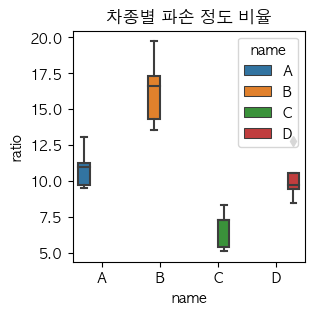

답안
데이터숫자가 적지만 정규분포와 등분산에 대한 가정을 조건으로 주었기 때문에 모수적 검정인 일원 분산분석을 통해서 그룹간 차이가 존재하는지 확인한다.
일원분산분석 p-value는 2.8174779556216382e-06로 차이가 유의하다고 볼 수 있다


In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/29/p7.csv')
plt.figure(figsize=(3,3))
sns.boxplot(x ='name', y='ratio',data =df,hue='name')
plt.title('차종별 파손 정도 비율')
plt.show()
# 일원 분산분석 수행
f_statistic, p_value = stats.f_oneway(df.query("name =='A'")['ratio'],
                                      df.query("name =='B'")['ratio'],
                                      df.query("name =='C'")['ratio'],
                                      df.query("name =='D'")['ratio'])

print('답안\n데이터숫자가 적지만 정규분포와 등분산에 대한 가정을 조건으로 주었기 때문에 모수적 검정인 일원 분산분석을 통해서 그룹간 차이가 존재하는지 확인한다.')
print(f'일원분산분석 p-value는 {p_value}로 차이가 유의하다고 볼 수 있다')

### 7-2 귀무가설을 채택한다면 그 의미를 해석하고, 귀무가설을 기각하였다면 사후분석을 시행하라.

In [ ]:
posthoc = pairwise_tukeyhsd(df['ratio'], df['name'], alpha=0.05)
display(posthoc.summary())
print('답안\n귀무가설은 "4개 그룹의 차이가 존재하지 않는다"이고 대립가설은 "4개 그룹들 중 차이가 있는 그룹이 존재한다"이다')
print('7-1에서 유의수준 0.05하에서 귀무가설을 기각하는 것을 보였다. tukey 사후분석을 진행하면 위의 데이터프레임과 같은 결과를 보인다.')
print('결과적으로 A와 D그룹을 비교했을때 p-value는 0.92로 귀무가설을 기각하지 못하고 나머지 모든 그룹쌍 사이에는 차이가 존재하는 것을 확인할 수 있다.')

group1,group2,meandiff,p-adj,lower,upper,reject
A,B,5.3934,0.001,2.1785,8.6083,True
A,C,-4.2156,0.0085,-7.4305,-1.0007,True
A,D,-0.7086,0.9207,-3.9235,2.5063,False
B,C,-9.609,0.0,-12.8239,-6.3941,True
B,D,-6.102,0.0003,-9.3169,-2.8871,True
C,D,3.507,0.0302,0.2921,6.7219,True


답안
귀무가설은 "4개 그룹의 차이가 존재하지 않는다"이고 대립가설은 "4개 그룹들 중 차이가 있는 그룹이 존재한다"이다
7-1에서 유의수준 0.05하에서 귀무가설을 기각하는 것을 보였다. tukey 사후분석을 진행하면 위의 데이터프레임과 같은 결과를 보인다.
결과적으로 A와 D그룹을 비교했을때 p-value는 0.92로 귀무가설을 기각하지 못하고 나머지 모든 그룹쌍 사이에는 차이가 존재하는 것을 확인할 수 있다.


## 8. L1,L2,L3 세 개의 생산라인에서 각각 13%, 37%, 50%를 생산하며 각각 1.1% , 2.1%, 3.3% 불량률을 갖는다. 불량 제품이 나왔을 때 L1 라인에서 생산되었을 확률을 구하시오. (소수점 둘째자리에서 반올림)

In [ ]:
# 주어진 확률
l1 = 0.13; l2 = 0.37; l3 = 0.50
ratio_l1 = 0.011; ratio_l2 = 0.021; ratio_l3 = 0.033

# 불량 제품이 나올 확률
ratio_t = ratio_l1 * l1 + ratio_l2 * l2 + ratio_l3 * l3

# 베이즈 정리를 사용하여 P(L1|불량) 계산
l1_ratio_t = (ratio_l1 * l1) / ratio_t
result = round(l1_ratio_t, 2)
print("답안\n베이즈 정리를 이용하면 다음과 같은 확률이 나온다", result)

답안
베이즈 정리를 이용하면 다음과 같은 확률이 나온다 0.06


created by datamanim [web-link](https://www.datamanim.com)

#### 끝. 10페이지